In [168]:
import glob
import re
import mne
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
N_CHANS = 62

## Channel coordinates

In [79]:
# Get coordinates of all channels 
epoch_paths = glob.glob('../data/bids/derivatives/preprocessing/*/*res-hi*fif.gz')
pattern = re.compile('sub-(\d{1,2})_')
epoch_sub_order = list(map(pattern.findall, epoch_paths))
epoch_sub_order = list(itertools.chain(*epoch_sub_order))

captrak_paths = glob.glob('../data/captrak/*.bvct')

poss = np.empty([])
# for each captrak file
for i, captrak_path in enumerate(captrak_paths):
    print(f"Reading captrak file: {captrak_path}")

    # get subject
    pattern = re.compile('subj-(\d{1,2})')
    sub = pattern.findall(captrak_path)[0]
    
    # get captrak file
    dig = mne.channels.read_dig_captrak(fname = captrak_path)
    
    # load epochs object for same subject
    ind = epoch_sub_order.index('43')
    epoch_fpath = epoch_paths[ind]
    print(f"Reading info from epoch file: {epoch_fpath}")
    info = mne.io.read_info(epoch_fpath)

    # get coordinates
    ch_names = info.ch_names
    if len(ch_names) != N_CHANS:
        print(f"ValueError: Incorrect number of channels, skipping subject {sub}!")
        continue
    try:
        pos = np.stack([dig.get_positions()['ch_pos'][ch] for ch in ch_names])
    except:
        print(f"KeyError: {captrak_path} is incomplete, likely missing FCz, skipping subject {sub}!")
        continue
        
    # Add to list
    pos = pos[..., np.newaxis]
    if i == 0:
        poss = pos
    else:
        poss = np.append(poss, pos, axis = 2)
    print(np.shape(poss))

Reading captrak file: ../data/captrak/subj-43.bvct
Reading info from epoch file: ../data/bids/derivatives/preprocessing/sub-43/sub-43_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz
(62, 3, 1)
Reading captrak file: ../data/captrak/subj-9.bvct
Reading info from epoch file: ../data/bids/derivatives/preprocessing/sub-43/sub-43_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz
(62, 3, 2)
Reading captrak file: ../data/captrak/subj-6.bvct
Reading info from epoch file: ../data/bids/derivatives/preprocessing/sub-43/sub-43_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz
KeyError: ../data/captrak/subj-6.bvct is incomplete, likely missing FCz, skipping subject 6!
Reading captrak file: ../data/captrak/subj-2.bvct
Reading info from epoch file: ../data/bids/derivatives/preprocessing/sub-43/sub-43_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz
KeyError: ../data/captrak/subj-2.bvct is incomplete, likely missing FCz, skipping subject 2!
Reading captrak file: ../data/captrak/subj-12.bvct
Reading info from epoch 

(62, 3, 37)
Reading captrak file: ../data/captrak/subj-24.bvct
Reading info from epoch file: ../data/bids/derivatives/preprocessing/sub-43/sub-43_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz
(62, 3, 38)
[[[-3.45798136e-02 -4.03329777e-02 -4.30959355e-02 ... -3.38404801e-02
   -3.15622009e-02 -3.81488411e-02]
  [ 9.76436831e-02  1.00070220e-01  1.06177751e-01 ...  1.13898279e-01
    1.01428837e-01  1.03252436e-01]
  [ 2.55071715e-02  7.17608909e-02  3.27082116e-02 ...  4.07238897e-02
    3.11106588e-02  3.92783616e-02]]

 [[-2.60604497e-03 -1.35907475e-02 -1.82862447e-02 ... -3.65524191e-03
   -1.76733731e-03 -1.04787079e-02]
  [ 8.39821174e-02  6.51294294e-02  9.43831735e-02 ...  9.43655408e-02
    9.49234204e-02  8.90886055e-02]
  [ 9.54993767e-02  1.36424090e-01  1.04719675e-01 ...  1.16071909e-01
    9.88697910e-02  1.09642013e-01]]

 [[-5.43411982e-02 -6.13528756e-02 -6.44515215e-02 ... -5.61891747e-02
   -4.81835777e-02 -6.16971050e-02]
  [ 7.32339505e-02  6.10997267e-02  8.08292

In [159]:
# Calculate mean coordinates
mean_pos = np.mean(poss, axis = 2)
x = mean_pos[:, 0]
y = mean_pos[:, 1]
z = mean_pos[:, 2]

## Mean coherence for each channel

In [160]:
# Read coherence files and append all to data frame
path = "../data/bids/derivatives/coherence/*_coh*"
coh = pd.DataFrame()
for fpath in glob.glob(path):
    data = pd.read_pickle(fpath)
    coh = pd.concat([coh, data])
coh = coh.set_index('index')

In [161]:
# Average over subjects
coh_sub_avg = coh.groupby(['cond', 'chan']).mean()

# Clean up
coh_sub_avg = coh_sub_avg.reset_index()
coh_sub_avg["cond"] = pd.to_numeric(coh_sub_avg["cond"])

In [162]:
# Broadcast coordinates
x = np.hstack([x]*5)
y = np.hstack([y]*5)
z = np.hstack([z]*5)

# Add coordinates to data frame
coh_sub_avg['x'], coh_sub_avg['y'], coh_sub_avg['z'] = [x, y, z]

In [163]:
# Subset coherence values by condition
coh_50 = coh_sub_avg[coh_sub_avg['cond'] == 50]
coh_100 = coh_sub_avg[coh_sub_avg['cond'] == 100]
coh_150 = coh_sub_avg[coh_sub_avg['cond'] == 150]
coh_200 = coh_sub_avg[coh_sub_avg['cond'] == 200]
coh_250 = coh_sub_avg[coh_sub_avg['cond'] == 250]

In [ ]:
# Subtract coherence values from baseline?

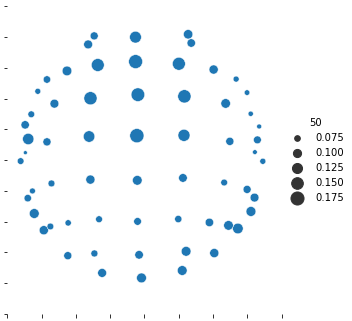

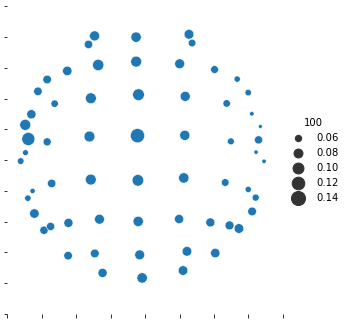

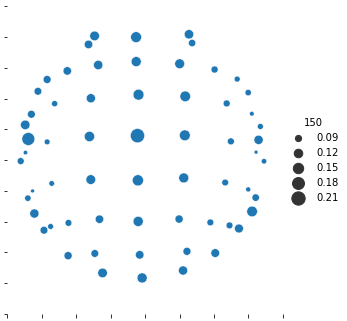

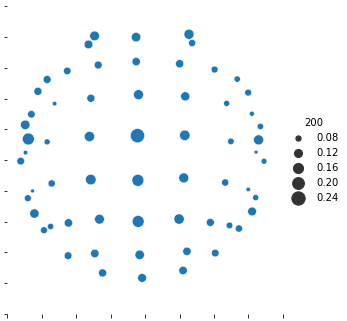

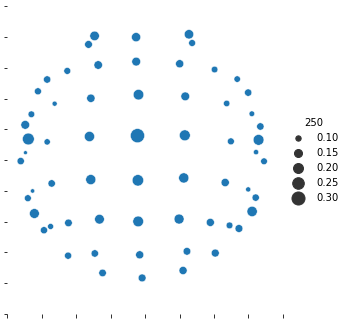

In [195]:
# Plot
ax = sns.relplot(x = "x", y = "y", size = "50", sizes=(15, 200), data = coh_50)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

ax = sns.relplot(x = "x", y = "y", size = "100", sizes=(15, 200), data = coh_100)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

ax = sns.relplot(x = "x", y = "y", size = "150", sizes=(15, 200), data = coh_150)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

ax = sns.relplot(x = "x", y = "y", size = "200", sizes=(15, 200), data = coh_200)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

ax = sns.relplot(x = "x", y = "y", size = "250", sizes=(15, 200), data = coh_250)
ax.despine(left = True, bottom = True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabels('')
ax.set_ylabels('')

In [ ]:
# Plot mean coordinates
rng = np.random.RandomState(0)
data = rng.normal(size=(N_CHANS, 1)) * 1e-6
fake_evoked = mne.EvokedArray(data, info)
fake_evoked.set_montage(dig)
fake_evoked.plot_sensors()

In [146]:
np.shape(np.hstack([z]*5))

(310,)

In [105]:
n_channels = 62
n_samples = 1
rng = np.random.RandomState(0)
data = rng.normal(size=(n_channels, 1)) * 1e-6
# info = mne.create_info(62, 5000, ch_types = 'eeg')
fake_evoked = mne.EvokedArray(data, epoch.info)
fake_evoked.set_montage(dig)
fake_evoked.plot_sensors()

ValueError: DigMontage is only a subset of info. There are 62 channel positions not present in the DigMontage. The required channels are:

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.

In [102]:
epochs_path = glob.glob('../data/bids/derivatives/preprocessing/*/*res-hi*')
pattern = re.compile('sub-(\d{1,2})_')
epoch_sub_order = list(map(pattern.findall, epochs_path))
epoch_sub_order = list(itertools.chain(*epoch_sub_order))

captrak_path = glob.glob('../data/captrak/*.bvct')
# pattern = re.compile('subj-(\d{1,2})')
# captrak_sub_order = list(map(pattern.findall, captrak_path))
# captrak_sub_order = list(itertools.chain(*captrak_sub_order))

# n_subs = len(captrak_path)
# poss = np.empty([n_subs, N_CHANS, 3])
poss = []
# for each captrak file
for file in captrak_path:
    # get subject
    pattern = re.compile('subj-(\d{1,2})')
    sub = pattern.findall(fpath)[0]
    
    # get corresponding captrak file
    dig = mne.channels.read_dig_captrak(fname = file)
    
    # load their epochs object
    ind = epoch_sub_order.index('43')
    epoch_fpath = epochs_path[ind]
    epochs = mne.read_epochs(epoch_fpath, preload = False)

    # get coordinates
    ch_names = epochs.ch_names
    if len(ch_names) != N_CHANS:
        print(f"Incorrect number of channels, skipping subjet {sub}")
        continue
    pos = np.stack([dig.get_positions()['ch_pos'][ch] for ch in ch_names])
    poss = [poss, pos]
    
# Plot mean coordinates
# rng = np.random.RandomState(0)
# data = rng.normal(size=(N_CHANS, 1)) * 1e-6
# fake_evoked = mne.EvokedArray(data, epoch.info)
# fake_evoked.set_montage(dig)
# fake_evoked.plot_sensors()
    

<Info | 8 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 62 misc
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 lowpass: 2500.0 Hz
 meas_date: unspecified
 nchan: 62
 projs: []
 sfreq: 5000.0 Hz
>